In [1]:
import numpy             as np
import scipy             as sp
import pandas            as pd
import scipy.optimize    as op
import matplotlib.pyplot as plt

import io
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import make_interp_spline

import re
from datetime import datetime

In [2]:
def mnkerr(x, y):
    p = np.polyfit(x, y, 1)
    cov = np.cov(x, y)
    da = 2*(1/(len(x) - 2) * (cov[1][1]/cov[0][0] - p[0]**2))**(0.5)
    db = da * (x**2).mean()
    return [da, db]

## Volumes

In [3]:
v_sf = 265

p_0  = [3.8, 3.6, 3.6]
p_1  = [220, 190, 190]
p_2  = [190, 180, 180]
p_3  = [140, 130, 130]

print(r"Откачка ДН               & {} & {} & {} \\".format(*p_0))
print(r"Открытие МК3             & {} & {} & {} \\".format(*p_1))
print(r"Открытие MK2             & {} & {} & {} \\".format(*p_2))
print(r"Открытие MK1             & {} & {} & {} \\".format(*p_3))

print("\n")

p_0  = np.mean(p_0)
p_1  = np.mean(p_1)
p_2  = np.mean(p_2)
p_3  = np.mean(p_3)

def calc_volume(p):
    return v_sf * (1e3 - p) / (p - p_0)

v_chamber = calc_volume(p_1)
v_pipes   = calc_volume(p_2) - v_chamber
v_full    = calc_volume(p_3)

print(r"Сильфон                  & ${v:5.0f} \pm {dv:3.0f}$ \\".format(v = v_sf,      dv = 0.05*v_sf))
print(r"Установка                & ${v:5.0f} \pm {dv:3.0f}$ \\".format(v = v_full,    dv = 0.05*v_full))
print(r"Камера                   & ${v:5.0f} \pm {dv:3.0f}$ \\".format(v = v_chamber, dv = 0.05*v_chamber))
print(r"Форвакуумная магистраль  & ${v:5.0f} \pm {dv:3.0f}$ \\".format(v = v_pipes,   dv = 0.05*np.sqrt(2)*v_pipes))


Откачка ДН               & 3.8 & 3.6 & 3.6 \\
Открытие МК3             & 220 & 190 & 190 \\
Открытие MK2             & 190 & 180 & 180 \\
Открытие MK1             & 140 & 130 & 130 \\


Сильфон                  & $  265 \pm  13$ \\
Установка                & $ 1771 \pm  89$ \\
Камера                   & $ 1080 \pm  54$ \\
Форвакуумная магистраль  & $  125 \pm   9$ \\


## Back-vacuum pumping speed

In [4]:
space = re.compile(r' ')
converters = {
    'B1'   : lambda x: float(space.split(x)[0].replace(',', '.')),
    'B2'   : lambda x: float(space.split(x)[0].replace(',', '.')),
    'time' : lambda x: datetime.strptime(x, '%Y-%m-%d, %H:%M:%S'),
}

types = {
    'B1' : np.double,
    'B2' : np.double,
}

In [5]:
II2_1 = pd.read_csv('data/back_vacuum_II2_1.txt', sep = '\t', converters=converters);
II2_1['time'] = (II2_1['time'] - II2_1['time'][0]).dt.total_seconds()

II2_2 = pd.read_csv('data/back_vacuum_II2_2.txt', sep = '\t', converters=converters);
II2_2['time'] = (II2_2['time'] - II2_2['time'][0]).dt.total_seconds()

II2_3 = pd.read_csv('data/back_vacuum_II2_3.txt', sep = '\t', converters=converters);
II2_3['time'] = (II2_3['time'] - II2_3['time'][0]).dt.total_seconds()

III2_1 = pd.read_csv('data/back_vacuum_III2_1.txt', sep = '\t', converters=converters);
III2_1['time'] = (III2_1['time'] - III2_1['time'][0]).dt.total_seconds()

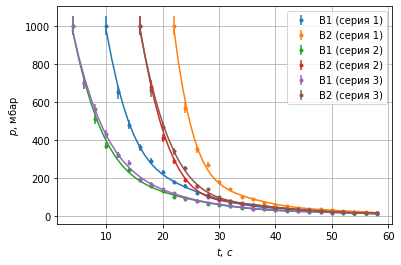

In [6]:
fr = 0
to = 30

def show(x, y, lbl, fr, to):
    spl = UnivariateSpline(x[fr:to], y[fr:to])
    spl.set_smoothing_factor(3e3)
    t = np.linspace(x[fr:to].min(), x[fr:to].max())
    p = plt.plot(t, spl(t))
    plt.errorbar(x[fr:to], y[fr:to], yerr = y[fr:to] * 0.05 , label=lbl, fmt = '.', c = p[0].get_color())
    
#show(II2_1['time'], II2_1['B1'], 'B1 (cерия 1)', 0, to)
#show(II2_1['time'], II2_1['B2'], 'В2 (cерия 1)', 0, to)
show(II2_2 ['time'], II2_2['B1'],  'В1 (cерия 1)', 5,  to)
show(II2_2 ['time'], II2_2['B2'],  'В2 (cерия 1)', 11, to)
show(II2_3 ['time'], II2_3['B1'],  'В1 (cерия 2)', 2,  to)
show(II2_3 ['time'], II2_3['B2'],  'В2 (cерия 2)', 8,  to)
show(III2_1['time'], III2_1['B1'], 'В1 (cерия 3)', 2,  to)
show(III2_1['time'], III2_1['B2'], 'В2 (cерия 3)', 8,  to)

plt.xlabel(r"$t$, $c$")
plt.ylabel(r"$p$, мбар")
plt.grid(True)
    
plt.legend()

plt.savefig('res/p(t).pdf')

$-0.0542 \pm 0.0029$     &    $5.952 \pm 8.530$ \\
$-0.0487 \pm 0.0029$     &    $5.407 \pm 8.590$ \\
$-0.0489 \pm 0.0028$     &    $5.462 \pm 8.199$ \\


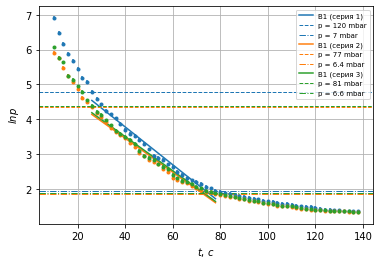

In [12]:
a = []
err_a = []
def lin(x, y, begin, end, fr, to, lbl):
    
    t = np.linspace(x[fr:to].min(), x[fr:to].max())
    cf = np.polyfit(x[fr:to], y[fr:to], 1)
    er = mnkerr(x[fr:to], y[fr:to])
    #print(cf, er)
    print(r'${a:.4f} \pm {ea:.4f}$     &    ${b:.3f} \pm {eb:.3f}$ \\'.format(a=cf[0], ea=er[0], b=cf[1], eb=er[1]))
    p = plt.plot(t, np.polyval(np.polyfit(x[fr:to], y[fr:to], 1), t), label=lbl)           
    plt.errorbar(x[begin:end], y[begin:end], yerr=0.05, fmt='.', c=p[0].get_color())
    
    plt.axhline(y=max(y[fr:to]), color = p[0].get_color(), linestyle='--', linewidth = 1, label = "p = {:.3g} mbar".format(np.e**max(y[fr:to])))
    plt.axhline(y=min(y[fr:to]), color = p[0].get_color(), linestyle='-.', linewidth = 1, label = "p = {:.3g} mbar".format(np.e**min(y[fr:to])))
    
    return cf[0], er[0]

tmp_a, tmp_err_a = lin(II2_2 ['time'], np.log(II2_2 ['B1']), 5, 70, 13, 40, 'B1 (cерия 1)')
a.append(tmp_a)
err_a.append(tmp_err_a)

tmp_a, tmp_err_a =lin(II2_3 ['time'], np.log(II2_3 ['B1']), 5, 70, 13, 40, 'B1 (cерия 2)')
a.append(tmp_a)
err_a.append(tmp_err_a)

tmp_a, tmp_err_a = lin(III2_1['time'], np.log(III2_1['B1']), 5, 70, 13, 40, 'B1 (cерия 3)')
a.append(tmp_a)
err_a.append(tmp_err_a)

plt.xlabel(r"$t$, $c$")
plt.ylabel(r"$lnp$")
plt.grid(True)
    
plt.legend(fontsize = 7)

plt.savefig('res/lnB1(t).pdf')

In [8]:
err_sys_a = max(np.abs(a - np.mean(a)))
err_a_av = (err_sys_a**2 + np.mean(err_a)**2)**0.5 # add systematic error

S = -np.mean(a) * (v_chamber + v_pipes) * 3600 / 1e6
err_S = S * err_a_av / (-np.mean(a))
print(r"$$S = aV = {:.3f} \pm {:.3f} \; \text{{м}}^3/\text{{ч}}$$".format(S, err_S))

$$S = aV = 0.263 \pm 0.021 \; \text{м}^3/\text{ч}$$


## Turbomolecular pumping speed

In [14]:
III3_1 = pd.read_csv('data/III3_1.txt', sep = '\t', converters=converters);
III3_1['time'] = (III3_1['time'] - III3_1['time'][30]).dt.total_seconds()
III3_2 = pd.read_csv('data/III3_2.txt', sep = '\t', converters=converters);
III3_2['time'] = (III3_2['time'] - III3_2['time'][0]).dt.total_seconds()
III3_3 = pd.read_csv('data/III3_3.txt', sep = '\t', converters=converters);
III3_3['time'] = (III3_3['time'] - III3_3['time'][0]).dt.total_seconds()

$-0.0078 \pm 0.0004$     &    $-9.964 \pm 2.249$ \\
$-0.0072 \pm 0.0008$     &    $-11.192 \pm 2.691$ \\
$-0.0080 \pm 0.0008$     &    $-11.349 \pm 2.843$ \\


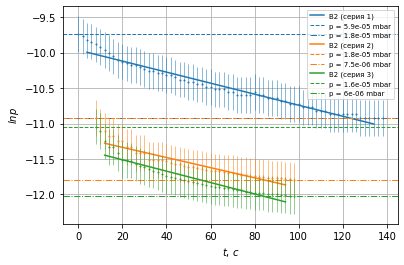

In [27]:
a = []
err_a = []
def lin(x, y, lbl):
    t = np.linspace(x[2:-2].min(), x[2:-2].max())
    #print(np.polyfit(x[2:-2], y[2:-2], 1), mnkerr(x[2:-2], y[2:-2]))
    cf = np.polyfit(x[2:-2], y[2:-2], 1)
    er = mnkerr(x[2:-2], y[2:-2])
    print(r'${a:.4f} \pm {ea:.4f}$     &    ${b:.3f} \pm {eb:.3f}$ \\'.format(a=cf[0], ea=er[0], b=cf[1], eb=er[1]))
    p = plt.plot(t, np.polyval(np.polyfit(x[2:-2], y[2:-2], 1), t), label=lbl)  
    plt.errorbar(x, y, yerr = 0.25, fmt='.', c=p[0].get_color(), elinewidth = 0.5, ms=2)
    
    plt.axhline(y=max(y), color = p[0].get_color(), linestyle='--', linewidth = 1, label = "p = {:.3g} mbar".format(np.e**max(y)))
    plt.axhline(y=min(y), color = p[0].get_color(), linestyle='-.', linewidth = 1, label = "p = {:.3g} mbar".format(np.e**min(y)))
    
    return cf[0], er[0]

fr = 30
to = 100
tmp_a, tmp_err_a = lin(III3_1['time'][fr:to], np.log(III3_1['B2'][fr:to]), 'B2 (cерия 1)')
a.append(tmp_a)
err_a.append(tmp_err_a)

fr = 4
to = 50
tmp_a, tmp_err_a = lin(III3_2['time'][fr:to], np.log(III3_2['B2'][fr:to]), 'B2 (cерия 2)')
a.append(tmp_a)
err_a.append(tmp_err_a)

tmp_a, tmp_err_a = lin(III3_3['time'][fr:to], np.log(III3_3['B2'][fr:to]), 'B2 (cерия 3)')
a.append(tmp_a)
err_a.append(tmp_err_a)

plt.xlabel(r"$t$, $c$")
plt.ylabel(r"$lnp$")
    
plt.legend(fontsize = 7)
plt.grid(True)

plt.savefig('res/TMHlnB2(t).pdf')

In [11]:
v_full = 1773 # Volume of the device

err_sys_a = max(np.abs(a - np.mean(a)))
err_a_av = (err_sys_a**2 + np.mean(err_a)**2)**0.5 # add systematic error

S = -np.mean(a) * v_chamber
err_S = S * err_a_av / -np.mean(a)
print(r"$$S = aV = {:.1f} \pm {:.1f} \; \text{{мл}}/\text{{с}}$$".format(S, err_S))

$$S = aV = 8.3 \pm 0.9 \; \text{мл}/\text{с}$$


## Normal leaks estimation

In [22]:
III4_1 = pd.read_csv('data/III4_1.txt', sep = '\t', converters=converters);
III4_1['time'] = (III4_1['time'] - III4_1['time'][0]).dt.total_seconds()
III4_2 = pd.read_csv('data/III4_2.txt', sep = '\t', converters=converters);
III4_2['time'] = (III4_2['time'] - III4_2['time'][0]).dt.total_seconds()
III4_3 = pd.read_csv('data/III4_3.txt', sep = '\t', converters=converters);
III4_3['time'] = (III4_3['time'] - III4_3['time'][0]).dt.total_seconds()

In [23]:
III4_1.head(10)

,time,Freq,W,B2,B1
0,0.0,1500 Hz,15 W,0.000051,0.00030
1,2.0,1500 Hz,15 W,0.000057,0.00035
2,4.0,1500 Hz,16 W,0.000064,0.00040
3,6.0,1500 Hz,16 W,0.000070,0.00045
4,8.0,1500 Hz,16 W,0.000078,0.00050
5,10.0,1500 Hz,16 W,0.000083,0.00055
6,12.0,1500 Hz,15 W,0.000091,0.00060
7,14.0,1500 Hz,15 W,0.000097,0.00065
8,16.0,1500 Hz,15 W,0.000100,0.00070
9,18.0,1500 Hz,16 W,0.000110,0.00070


$2.67e-05 \pm 5.19e-07$     &    $2.69e-04 \pm 1.07e-03$ \\
$2.06e-05 \pm 3.51e-07$     &    $1.16e-04 \pm 1.38e-03$ \\
$2.10e-05 \pm 4.18e-07$     &    $1.47e-04 \pm 1.35e-03$ \\


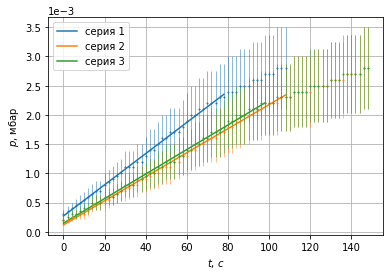

In [24]:
a = []
err_a = []

def lin(data, start, stop, label):
    x = data['time'][start:stop]
    y = data['B1'][start:stop]
    t = np.linspace(x.min(), x.max())
    cf = np.polyfit(x, y, 1)
    er = mnkerr(x, y)
    print(r'${a:.2e} \pm {ea:.2e}$     &    ${b:.2e} \pm {eb:.2e}$ \\'.format(a=cf[0], ea=er[0], b=cf[1], eb=er[1]))
    p = plt.plot(t, np.polyval(np.polyfit(x, y, 1), t), label=label)
    plt.ticklabel_format(axis = 'y', scilimits=(0,0))
    plt.errorbar(data['time'], data['B1'], yerr = 0.25 * data['B1'], fmt='.', c=p[0].get_color(), elinewidth = 0.5, ms=2)
    
    return cf[0], er[0]

t_a, t_err = lin(III4_1, 0, 40, "серия 1")
a.append(t_a)
err_a.append(t_err)

t_a, t_err = lin(III4_2, 0, 55, "серия 2")
a.append(t_a)
err_a.append(t_err)

t_a, t_err = lin(III4_3, 0, 50, "серия 3")
a.append(t_a)
err_a.append(t_err)

plt.xlabel(r"$t$, $c$")
plt.ylabel(r"$p$, мбар")
plt.legend()
plt.grid(True)

plt.savefig('res/leaks.pdf')

In [25]:
q = v_chamber * np.array(a)
q_err = np.std(q)

print(r"$$Q_{{\text{{н}}}} = ({:.3f} \pm {:.3f}) \; \frac{{\text{{мл}}\cdot\text{{мбар}}}}{{\text{{с}}}}$$".
      format(np.mean(q), q_err))

$$Q_{\text{н}} = (0.025 \pm 0.003) \; \frac{\text{мл}\cdot\text{мбар}}{\text{с}}$$


In [26]:
def calc_q(data):
    return (data['B1'] - data['B1'][0]) / data['time'] * v_chamber

print(v_chamber)

q1 = calc_q(III4_1)
q2 = calc_q(III4_2)
q3 = calc_q(III4_3)

q1[0] = 0
q2[0] = 0
q3[0] = 0

1079.7962648556875


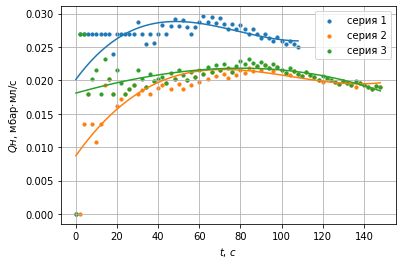

In [27]:
fro = 0

def lin(data, q, label):
    plt.scatter(data['time'][fro:], q[fro:], label = label, s = 10)
    
    t = np.linspace(data['time'][fro:].min(), data['time'][fro:].max(), 100)
    spl = UnivariateSpline(data['time'][fro:], q[fro:])
    spl.set_smoothing_factor(1)
    plt.plot(t, spl(t))

lin(III4_1, q1, "серия 1")
lin(III4_2, q2, "серия 2")
lin(III4_3, q3, "серия 3")

plt.xlabel(r"$t$, $c$")
plt.ylabel(r"$Qн$, мбар$\cdot$мл/c")
plt.legend()
plt.grid(True)

plt.savefig('res/Q(t).pdf')

### Unfortunately, that's all

But feel free to upgrade and continue this lab report and post it on your repository.

Sometime in the future we'll come to the end...